<a href="https://colab.research.google.com/github/Tiru-Kaggundi/Trade_AI/blob/main/final_dataset_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Setup
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Colab mount (safe if not in Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = Path('/content/drive/MyDrive/ai4trade')
except Exception:
    BASE_DIR = Path.home() / 'ai4trade'

INTERIM = BASE_DIR / 'data' / 'interim'
OUT_PATH = INTERIM / 'final_clean_data.parquet'

print("Interim dir:", INTERIM)
print("Output path:", OUT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Interim dir: /content/drive/MyDrive/ai4trade/data/interim
Output path: /content/drive/MyDrive/ai4trade/data/interim/final_clean_data.parquet


In [2]:
#@title List target files to merge
expected_pairs = [
    ("CHN","exports"), ("CHN","imports"),
    ("USA","exports"), ("USA","imports"),
]
years = [2023, 2024, 2025]

files = []
for c, f in expected_pairs:
    for y in years:
        p = INTERIM / f"{c}_{f}_{y}_key_partners.parquet"
        if p.exists():
            files.append(p)
        else:
            print(f"⚠️ Missing (ok if not produced): {p.name}")

print(f"\nWill attempt to load {len(files)} files:")
for p in sorted(files):
    print("  •", p.name)


Will attempt to load 12 files:
  • CHN_exports_2023_key_partners.parquet
  • CHN_exports_2024_key_partners.parquet
  • CHN_exports_2025_key_partners.parquet
  • CHN_imports_2023_key_partners.parquet
  • CHN_imports_2024_key_partners.parquet
  • CHN_imports_2025_key_partners.parquet
  • USA_exports_2023_key_partners.parquet
  • USA_exports_2024_key_partners.parquet
  • USA_exports_2025_key_partners.parquet
  • USA_imports_2023_key_partners.parquet
  • USA_imports_2024_key_partners.parquet
  • USA_imports_2025_key_partners.parquet


In [3]:
def read_and_standardize(path: Path) -> pd.DataFrame:
    df = pd.read_parquet(path)

    # Require canonical columns
    req = {'origin','destination','hs6','hs4','trade_flow','month','value'}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"{path.name} missing columns: {missing}")

    # Types / cleaning
    df['origin'] = df['origin'].astype(str).str.upper()
    df['destination'] = df['destination'].astype(str).str.upper()
    df['trade_flow'] = df['trade_flow'].astype(str).str.capitalize()  # Export/Import

    # Clean hs6 robustly (preserve leading zeros)
    df['hs6'] = (
        df['hs6'].astype(str)
          .str.replace(r'[^0-9]', '', regex=True)
          .str.zfill(6)
          .str[:6]
    )
    # **Always** recompute hs4 from hs6 (don’t trust incoming hs4)
    df['hs4'] = df['hs6'].str[:4]

    df['month'] = pd.to_datetime(df['month'], errors='coerce')
    df = df.dropna(subset=['month'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce').fillna(0.0)

    # Sanity: verify alignment
    assert df['hs6'].str.len().eq(6).all()
    assert df['hs4'].str.len().eq(4).all()
    assert (df['hs4'] == df['hs6'].str[:4]).all()

    return df

In [4]:
#@title Merge all key-partner parquets
frames = [read_and_standardize(p) for p in files]
merged = pd.concat(frames, axis=0, ignore_index=True)

# Remove complete duplicates (if any)
before = len(merged)
merged = merged.drop_duplicates()
after = len(merged)
print(f"Merged rows: {before:,} → after drop_duplicates: {after:,}")

# Light validations
assert merged['origin'].isin(['CHN','USA']).all()
assert merged['trade_flow'].isin(['Export','Import']).all()
assert merged['hs6'].str.len().eq(6).all()
assert merged['hs4'].str.len().eq(4).all()

# Add year & month_id for convenience
merged['year'] = merged['month'].dt.year
merged['month_id'] = merged['month'].dt.to_period('M').astype(str)

# Quick availability peek
print("\nDate ranges by (origin, flow):")
for (o,f), g in merged.groupby(['origin','trade_flow']):
    print(f"  {o} {f:<6} : {g['month'].min().date()} → {g['month'].max().date()}  rows={len(g):,}")

# Save final parquet
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
merged[['origin','destination','hs6','hs4','trade_flow','month','value']].to_parquet(OUT_PATH, index=False)
print(f"\n✅ Saved {OUT_PATH}")

Merged rows: 9,173,254 → after drop_duplicates: 9,173,254

Date ranges by (origin, flow):
  CHN Export : 2023-01-01 → 2025-08-01  rows=3,059,124
  CHN Import : 2023-01-01 → 2025-08-01  rows=1,261,279
  USA Export : 2023-01-01 → 2025-07-01  rows=2,605,360
  USA Import : 2023-01-01 → 2025-07-01  rows=2,247,491

✅ Saved /content/drive/MyDrive/ai4trade/data/interim/final_clean_data.parquet


In [5]:
#@title Plot helper (one chart per call)
def plot_monthly_total(df, origin, flow, title_suffix="(USD billions)"):
    sub = df[(df['origin']==origin) & (df['trade_flow']==flow)].copy()
    if sub.empty:
        print(f"No data for {origin} {flow}")
        return
    m = (
        sub.groupby(sub['month'].dt.to_period('M'))['value']
           .sum()
           .to_timestamp()
           .sort_index()
           .div(1e9)
    )
    plt.figure(figsize=(10,4))
    m.plot()
    plt.title(f"{origin} {flow} — Monthly Total {title_suffix}")
    plt.xlabel("Month")
    plt.ylabel("USD billions")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

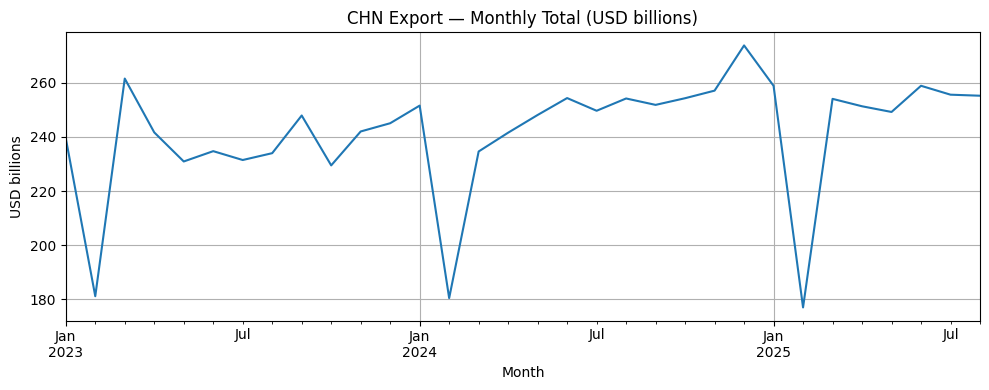

In [6]:
#@title CHN Exports — monthly plot
plot_monthly_total(merged, origin="CHN", flow="Export")

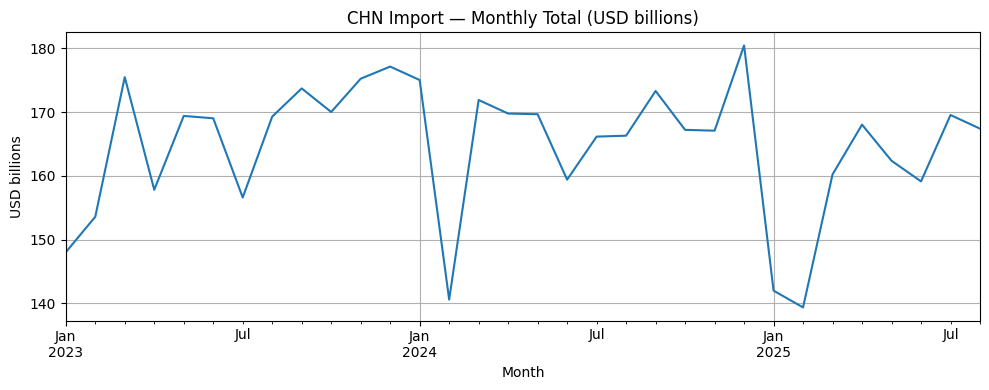

In [7]:
#@title CHN Imports — monthly plot
plot_monthly_total(merged, origin="CHN", flow="Import")

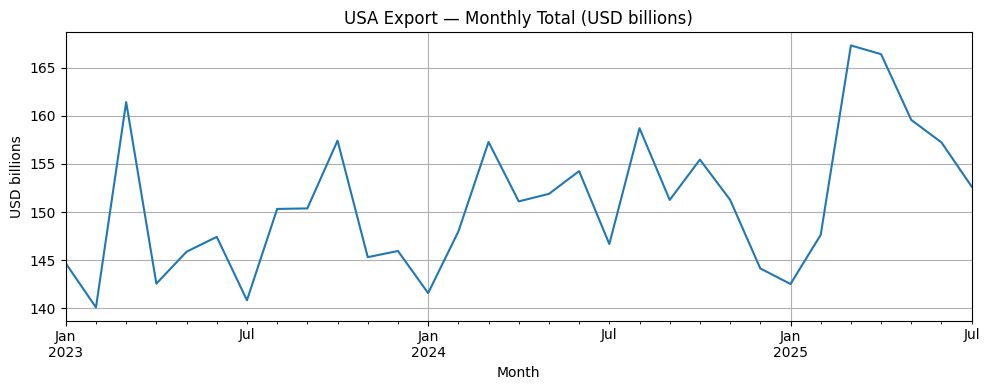

In [8]:
#@title USA Exports — monthly plot
plot_monthly_total(merged, origin="USA", flow="Export")

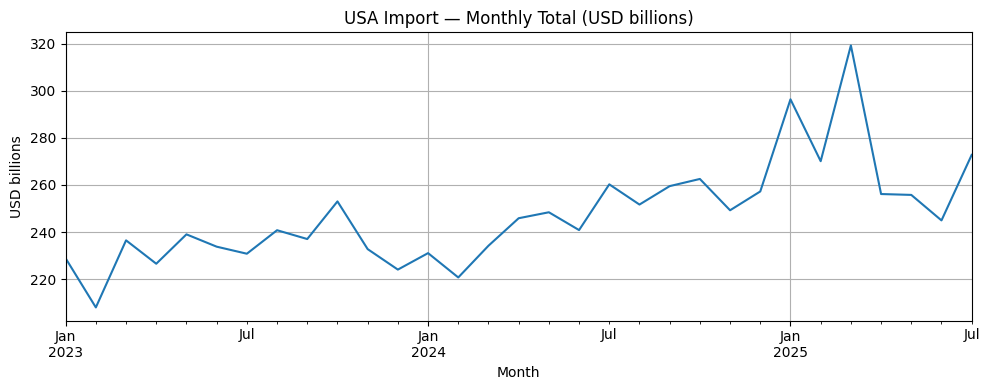

In [9]:
#@title USA Imports — monthly plot
plot_monthly_total(merged, origin="USA", flow="Import")

In [10]:
#@title Optional: quick tables (row counts & partner counts)
summary = (
    merged
    .groupby(['origin','trade_flow','year'])
    .agg(rows=('value','size'),
         partners=('destination','nunique'),
         hs6=('hs6','nunique'),
         hs4=('hs4','nunique'),
         value_total=('value','sum'))
    .reset_index()
)
display(summary.assign(value_total_bln = summary['value_total']/1e9)
               .drop(columns=['value_total'])
               .sort_values(['origin','trade_flow','year']))

,origin,trade_flow,year,rows,partners,hs6,hs4,value_total_bln
0,CHN,Export,2023,1166037,30,5190,1210,2819.156033
1,CHN,Export,2024,1147628,30,5193,1208,2951.129322
2,CHN,Export,2025,745459,30,5125,1206,1959.920923
3,CHN,Import,2023,488793,29,5030,1191,1995.291338
4,CHN,Import,2024,488714,29,5010,1193,2006.866509
5,CHN,Import,2025,283772,29,4881,1183,1268.006703
6,USA,Export,2023,1089752,30,5502,1226,1772.219752
7,USA,Export,2024,1082754,30,5490,1227,1811.526085
8,USA,Export,2025,432854,30,5433,1225,1093.266007
9,USA,Import,2023,926401,30,5478,1227,2791.418062


In [11]:
display(merged.head())

,origin,destination,hs6,hs4,trade_flow,month,value,year,month_id
0,CHN,ARE,010619,0106,Export,2023-02-01,200,2023,2023-02
1,CHN,ARE,010619,0106,Export,2023-07-01,600,2023,2023-07
2,CHN,ARE,010619,0106,Export,2023-08-01,300,2023,2023-08
3,CHN,ARE,010619,0106,Export,2023-09-01,800,2023,2023-09
4,CHN,ARE,010619,0106,Export,2023-10-01,600,2023,2023-10
